In [1]:
import torch
import torchvision.datasets as datasets
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed here
import random
import numpy as np
seed = 123459
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [2]:
def compute_FID(image_r, image_f):
    _ = torch.manual_seed(1982)
    fid = FrechetInceptionDistance(feature=64)
    fid.update(image_r, real=True)
    fid.update(image_f, real=False)
    FID = fid.compute()
    return FID


def encode_image(img):
    transform = transforms.Compose([transforms.PILToTensor()])
    return transform(img)

def load_data(train_loader, test_loader, sample, dims):
    _, (train, targets) = next(enumerate(train_loader))
    _, (test, targets) = next(enumerate(test_loader))
    train_tensor = train.expand([sample, 3, dims[0], dims[1]])
    test_tensor = test.expand([sample, 3, dims[0], dims[1]])
    return train_tensor, test_tensor

def compute_transform_FID(transform, factor, dataset_train, dataset_test):
    transform_test = torch.clone(dataset_test)
    transformed_test = transform(dataset_test, factor)
    return compute_FID(dataset_train, transformed_test).item()

def plot_FID(factor_array, transformation, transform_name, dataset_train, dataset_test):
    transformed_FID = [compute_transform_FID(transformation, x, dataset_train, dataset_test) for x in factor_array]
    plt.plot(factor_array, transformed_FID)
    plt.xlabel(transform_name)
    plt.ylabel("FID Score")
    return None

## Data Sets

In [3]:
# MNIST
MNIST_train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);

MNIST_test_loader =  DataLoader(datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);
MNIST_train, MNIST_test = load_data(MNIST_train_loader, MNIST_test_loader, 1000, (28, 28))

# Base FID
print(f"Base FID MNIST: {compute_FID(MNIST_train, MNIST_test).item()}")

Base FID MNIST: 0.0016129440627992153


In [4]:
# CIFAR 100
CIFAR_train_loader = DataLoader(datasets.CIFAR100('./data', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);

CIFAR_test_loader =  DataLoader(datasets.CIFAR100('./data', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);
CIFAR_train, CIFAR_test = load_data(CIFAR_train_loader, CIFAR_test_loader, 1000, (32, 32))

# Base FID
print(f"Base FID CIFAR: {compute_FID(CIFAR_train, CIFAR_test).item()}")

Files already downloaded and verified
Files already downloaded and verified
Base FID CIFAR: 0.015043470077216625


In [5]:
# CelebA
CelebA_train_loader = DataLoader(datasets.CelebA('./data', split="train", download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);

CelebA_test_loader =  DataLoader(datasets.CelebA('./data', split="test", download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);
CelebA_train, CelebA_test = load_data(CelebA_train_loader, CelebA_test_loader, 1000, (218, 178))

# Base FID
print(f"Base FID CelebA: {compute_FID(CelebA_train, CelebA_test).item()}")

Files already downloaded and verified
Files already downloaded and verified
Base FID CelebA: 0.02807309292256832


## Gamma Correction

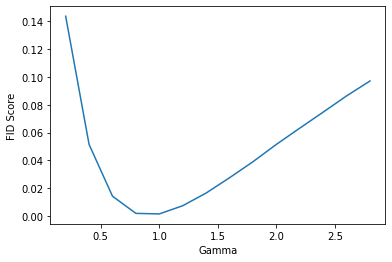

In [6]:
gamma_array = np.arange(0.2, 3.0, 0.2)
plot_FID(gamma_array, transforms.functional.adjust_gamma, "Gamma", MNIST_train, MNIST_test)
plt.savefig("plots/MNIST_gamma_fid_scores")

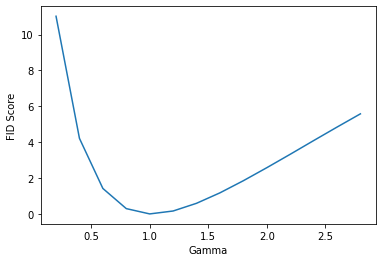

In [7]:
plot_FID(gamma_array, transforms.functional.adjust_gamma, "Gamma", CIFAR_train, CIFAR_test)
plt.savefig("plots/CIFAR_gamma_fid_scores")

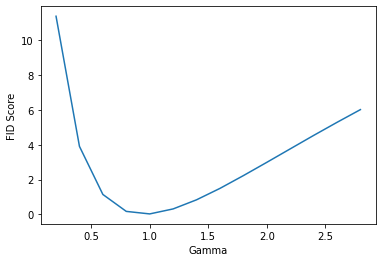

In [8]:
plot_FID(gamma_array, transforms.functional.adjust_gamma, "Gamma", CelebA_train, CelebA_test)
plt.savefig("plots/CelebA_gamma_fid_scores")

## Image Saturation

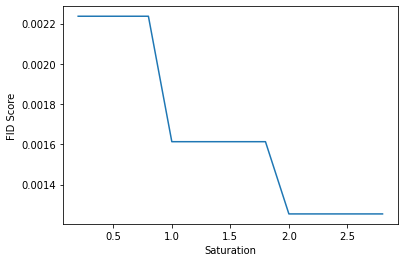

In [9]:
level_array = np.arange(0.2, 3.0, 0.2)
plot_FID(level_array, transforms.functional.adjust_saturation, "Saturation", MNIST_train, MNIST_test)
plt.savefig("plots/MNIST_saturation_fid_scores")

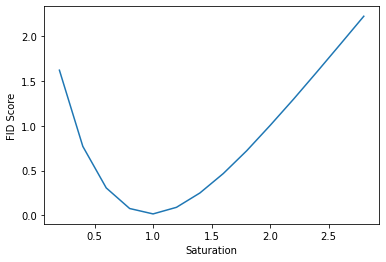

In [10]:
plot_FID(level_array, transforms.functional.adjust_saturation, "Saturation", CIFAR_train, CIFAR_test)
plt.savefig("plots/CIFAR_saturation_fid_scores")

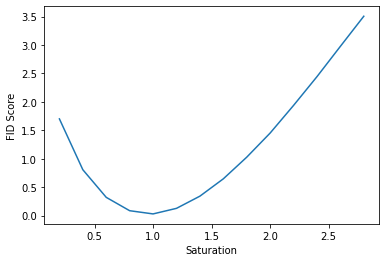

In [11]:
plot_FID(level_array, transforms.functional.adjust_saturation, "Saturation", CelebA_train, CelebA_test)
plt.savefig("plots/CelebA_saturation_fid_scores")

## Image Sharpening

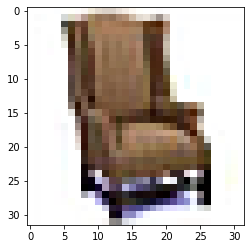

In [12]:
data_set_sharpened = torch.clone(CIFAR_test)
data_set_sharpened = transforms.functional.adjust_sharpness(data_set_sharpened, 3)
display = transforms.functional.to_pil_image(data_set_sharpened[1])
plt.imshow(display)

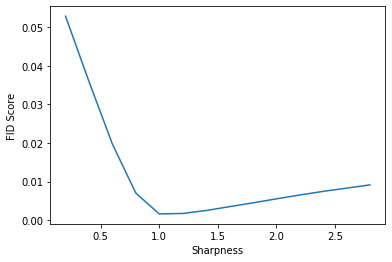

In [13]:
level_array = np.arange(0.2, 3.0, 0.2)
plot_FID(level_array, transforms.functional.adjust_sharpness, "Sharpness", MNIST_train, MNIST_test)
plt.savefig("plots/MNIST_sharpness_fid_scores")

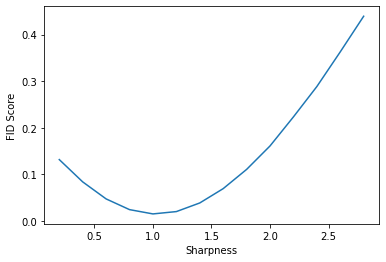

In [14]:
plot_FID(level_array, transforms.functional.adjust_sharpness, "Sharpness", CIFAR_train, CIFAR_test)
plt.savefig("plots/CIFAR_sharpness_fid_scores")

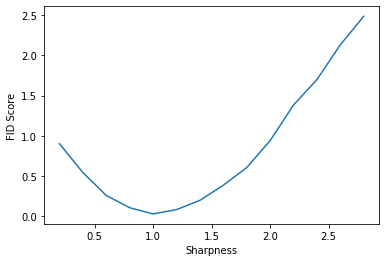

In [15]:
plot_FID(level_array, transforms.functional.adjust_sharpness, "Sharpness", CelebA_train, CelebA_test)
plt.savefig("plots/CelebA_sharpness_fid_scores")

## Gaussian Blur

In [16]:
import seaborn as sns
from itertools import product

def generate_heatmap(dataset_train, dataset_test, dataset):
    kernel_sizes = np.arange(1, 13, 2)
    coords = np.array(list(product(kernel_sizes, kernel_sizes)))
    heat_matrix = np.zeros((6, 6))
    for c in coords:
        heat_matrix[c[0]//2, c[1]//2] = compute_transform_FID(
        transforms.functional.gaussian_blur, tuple(c), dataset_train, dataset_test)
    plot = sns.heatmap(heat_matrix, annot=True, xticklabels=kernel_sizes, yticklabels=kernel_sizes, cmap=sns.diverging_palette(220, 20, as_cmap=True))
    plot.get_figure().savefig('plots/' + dataset + '_blurring_FID.png', dpi=400)
    return None

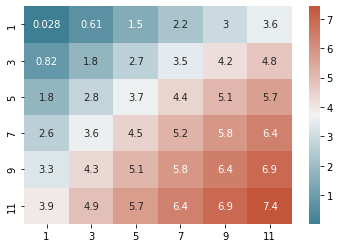

In [17]:
generate_heatmap(CelebA_train, CelebA_test, "CelebA")

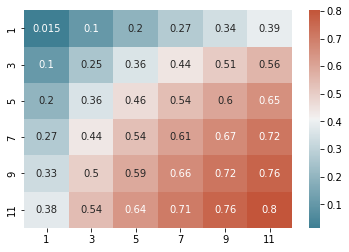

In [18]:
generate_heatmap(CIFAR_train, CIFAR_test, "CIFAR")

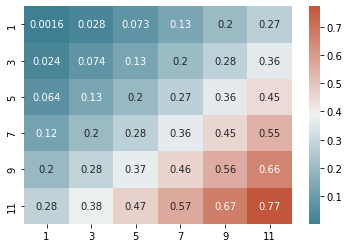

In [19]:
generate_heatmap(MNIST_train, MNIST_test, "MNIST")

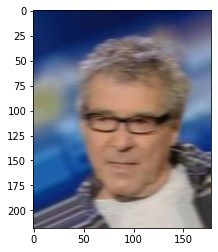

In [20]:
data_set_blurred = torch.clone(CelebA_test)
data_set_blurred = transforms.functional.gaussian_blur(data_set_blurred, [13, 1])
display = transforms.functional.to_pil_image(data_set_blurred[1])
plt.imshow(display)

In [21]:
compute_transform_FID(transforms.functional.gaussian_blur, [13,1] , CelebA_train, CelebA_test)

4.400077819824219

In [22]:
compute_transform_FID(transforms.functional.gaussian_blur, [9,9] , MNIST_train, MNIST_test)

0.5596179366111755

In [23]:
compute_transform_FID(transforms.functional.gaussian_blur, [9,9] , CIFAR_train, CIFAR_test)

0.7197607159614563

## Salt and Pepper Noise

In [24]:
from skimage.util import random_noise

def noisify_FID(amount, dataset_train, dataset_test, print_pic=False):
    noised_test = torch.clone(dataset_test)
    noised_test = torch.tensor(random_noise(noised_test, mode="s&p", rng=seed, amount=amount))
    noised_test = noised_test*255
    noised_test = noised_test.type(torch.uint8)
    if print_pic:
        display = transforms.functional.to_pil_image(noised_test[1])
        plt.imshow(display)
    return compute_FID(dataset_train, noised_test).item()

CIFAR Noisy FID: 0.8797504305839539


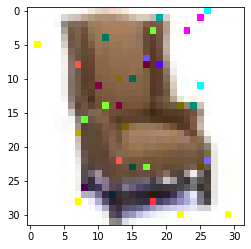

In [25]:
print(f"CIFAR Noisy FID: {noisify_FID(0.02, CIFAR_train, CIFAR_test, True)}")

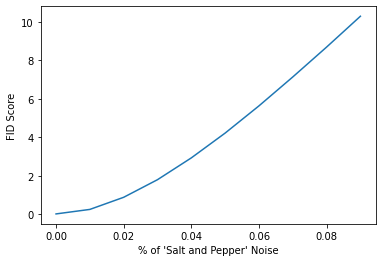

In [26]:
percentages = np.arange(0, 0.1, 0.01)
noise_FID_results = [noisify_FID(p, CIFAR_train, CIFAR_test) for p in percentages]
plt.plot(percentages, noise_FID_results)
plt.xlabel("% of 'Salt and Pepper' Noise")
plt.ylabel("FID Score")
plt.savefig("plots/CIFAR_Noise_fid_scores")

CIFAR Noisy FID: 12.316861152648926


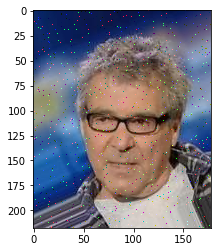

In [27]:
print(f"CIFAR Noisy FID: {noisify_FID(0.01, CelebA_train, CelebA_test, True)}")

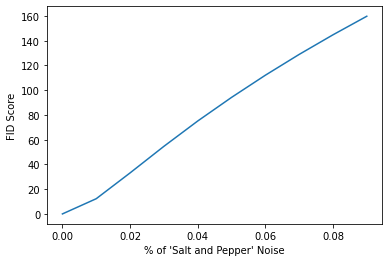

In [28]:
noise_FID_results = [noisify_FID(p, CelebA_train, CelebA_test) for p in percentages]
plt.plot(percentages, noise_FID_results)
plt.xlabel("% of 'Salt and Pepper' Noise")
plt.ylabel("FID Score")
plt.savefig("plots/CelebA_Noise_fid_scores")

## Image Rotation

In [29]:
angles = [90, 180, 270]
for angle in angles:
    print(f"------- Rotation of {angle} degrees -------")
    print(f"MNIST: {compute_transform_FID(transforms.functional.rotate, angle, MNIST_train, MNIST_test)}")
    print(f"CIFAR: {compute_transform_FID(transforms.functional.rotate, angle, CIFAR_train, CIFAR_test)}")

------- Rotation of 90 degrees -------
MNIST: 0.01788938231766224
CIFAR: 0.027028370648622513
------- Rotation of 180 degrees -------
MNIST: 0.0017155950190499425
CIFAR: 0.02177812159061432
------- Rotation of 270 degrees -------
MNIST: 0.01797214336693287
CIFAR: 0.027506351470947266


In [30]:
# CelebA is rectangle, so only 180 degree is possible
print(f"CelebA 180 degrees: {compute_transform_FID(transforms.functional.rotate, 180, CelebA_train, CelebA_test)}")

CelebA 180 degrees: 0.03830832988023758


## Sectional Rotations

In [31]:
# We rotate a section of the test images upside-down
def rotate_chunk(grid, dataset_train, dataset_test):
    x1, y1, x2, y2 = grid
    dataset_test_rotated = torch.clone(dataset_test)
    dataset_test_rotated[:, :, y1:y2,x1:x2] = transforms.functional.rotate(dataset_test_rotated[:, :, y1:y2, x1:x2], 180)
    display = transforms.functional.to_pil_image(dataset_test_rotated[1])
    plt.imshow(display)
    return compute_FID(dataset_train, dataset_test_rotated).item()

MNIST: 0.005982075352221727


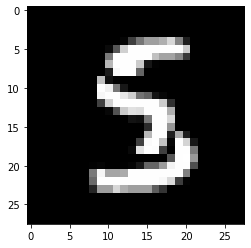

In [32]:
print(f"MNIST: {rotate_chunk((9, 9, 19, 19), MNIST_train, MNIST_test)}")

CIFAR: 0.01990210823714733


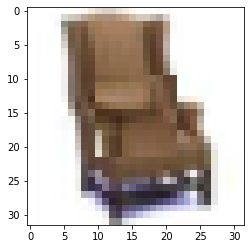

In [33]:
print(f"CIFAR: {rotate_chunk((10, 10, 22, 22), CIFAR_train, CIFAR_test)}")

CelebA: 0.04533012583851814


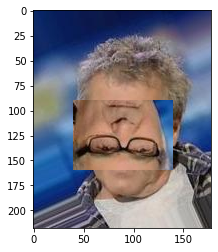

In [34]:
print(f"CelebA: {rotate_chunk((40, 90, 140, 160), CelebA_train, CelebA_test)}")